## Analyze A/B Test Results

#### Author/Analyst: Leon Hamnett
#### [LinkedIn](https://www.linkedin.com/in/leon-hamnett/)


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Conclusions](#conclusions) 


<a id='intro'></a>
### Introduction

In this notebook we will be working to understand the results of an A/B test run by an e-commerce website. Throughout this notebook we will try to help the company understand if they should implement a new page design, keep the old page design, or perhaps run the experiment longer to make their decision.

In the data we can see a user_id, a time when they accessed the page, and whether they were in the control group and were shown the old website page or in the 'treatment' group and were shown the new version of the website. We also see if they were converted to spend money on the website.

To come up with an actionable decision, we will be using a mix of techniques; incuding probability, A/B tests (sampling distributions and z-statistics) and logistic regression.


<a id='probability'></a>
#### Part I - Probability

Firstly we'll examine the data using probabilities.

We'll import the libaries we'll be using during the analysis:

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

We read and examine the data:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Check the shape:

In [4]:
df.shape[0]

294478

Check the number of unique users in the dataset:

In [5]:
len(df['user_id'].unique())

290584

Check the proportion of users converted:

In [6]:
#check unique users who converted
uniq_convert = df.query('converted == "1"').groupby(by='user_id',axis=0)
#check proportion of unique users who converted
prop_convert = len(uniq_convert)/df.shape[0]
prop_convert

0.1194418598333322

Check the number of times the `new_page` and `treatment` columns don't match as this shows an error in the data as these should always match.

In [7]:
a= len(df[(df['group']=='control') & (df['landing_page']=='new_page')])
b = len(df[(df['group']=='treatment') & (df['landing_page']=='old_page')])
print('control and new page mismatch: ',a)
print('treatment and old page mismatch: ',b)
print('total mismatches: ',a+b)

control and new page mismatch:  1928
treatment and old page mismatch:  1965
total mismatches:  3893


Check if any of the rows have missing values:

In [8]:
df.info()
#we see no rows have missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. We will investigate further to see if we can see a pattern or another method to correct this incorrect data. 

Create a new dataframe with just the mismatched rows:

In [9]:
#create new data frame with all mismatched rows
mismatch = df[(df['group']=='control') & (df['landing_page']=='new_page')]
mismatch2 = df[(df['group']=='treatment') & (df['landing_page']=='old_page')]
mismatch_all = pd.concat([mismatch,mismatch2],axis=0,join='outer')
# check rows affected for similarities
print('mismatched rows: ',mismatch_all.shape[0])
#we have no method to verify which value is correct
#as number of rows is not a large percentage of total rows, we can drop these rows
df2 = df.drop(index=mismatch_all.index)
#check rows have been deleted correctly
print('original row count: ',df.shape[0])
print('new row count: ',df2.shape[0])

mismatched rows:  3893
original row count:  294478
new row count:  290585


In [10]:
# Double check all of the rows with this error were removed 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Check how many unique **user_id**s are in **df2** (dataframe with incorrect values for treatment removed):

In [11]:
len(df2['user_id'].unique())

290584

Check for duplicate rows:

In [12]:
df2.loc[df2['user_id'].duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Check duplicate entries:

In [13]:
df2.loc[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove one of the rows with a duplicate **user_id**:

In [14]:
#we choose to keep the earliest instance of the duplicate
#drop the second instance
df2.drop(index=2893,inplace=True)
#check dup has been removed
df2.loc[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


Check what is the probability of an individual converting regardless of the page they receive:

In [15]:
#we find the probability of an unique individual converting
prob_convert = len(df2.query('converted=="1"').groupby(by='user_id'))/len(df2.groupby(by='user_id'))
prob_convert

0.11959708724499628

Given that an individual was in the `control` group, we check the probability they converted:

In [16]:
#we find the probability of an unique individual converting if they were in the control group
control = df2.query('group=="control"')
prob_control_converted = len(control.query('converted=="1"').groupby(by='user_id'))/len(control.groupby(by='user_id'))
prob_control_converted

0.1203863045004612

Given that an individual was in the `treatment` group, we check the probability they converted:

In [17]:
#we find the probability of an unique individual converting if they were in the treatment group
treatment = df2.query('group=="treatment"')
prob_treat_converted = len(treatment.query('converted=="1"').groupby(by='user_id'))/len(treatment.groupby(by='user_id'))
prob_treat_converted

0.11880806551510564

We check the probability that an individual received the new page:

In [18]:
#we find the probability of an unique individual being shown the new page
prob_new_page = len(df2.query('landing_page=="new_page"').groupby(by='user_id'))/len(df2.groupby(by='user_id'))
prob_new_page

0.5000619442226688

#### Inferences:

Considering that we see the probability an individual converts, is almost the same whether they were shown the old page or the new page, and the probability an individual converts when shown the new page is almost the same as the chance an indivual converts regardless of the page they were shown. 

I would conclude there is not sufficient evidence to decide with certainty that the new page leads to more conversions. 

<a id='ab_test'></a>
### Part II - A/B Test

Secondly we'll examine the data using hypothesis tests to check the results of the a/b test.

We assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5% (0.95 confidence) and thus set up the null and alternative hypothesis' as follows:

$H_{0}$ (null) : $P_{new}$ - $P_{old}$  <= 0

$H_{A}$  (alternative) : $P_{new}$ - $P_{old}$  > 0 

Where P-new is the proportion of users who convert after being shown the new page and P-old is the proportion of users who convert even when they were shown the old page (baseline).

#### Method 1: Edge case and simulated distribution:

The method we will use in the first case to evaluate the null hypothesis is to take an edge value, one that is within the null hypothesis but is very close to being in the alternative hypothesis. In this case when the difference in propertions is zero. We will then check the sampling distribution for this case and then see where our actual data falls within the distribution.

First we assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page a user sees. <br><br>

We use a sample size for each page equal to the sample sizes in **ab_data.csv**.  And then we will create the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Check the **conversion rate** for $p_{new}$ under the null:

In [19]:
#find conversion rate for p-new
new_cr = prob_convert
new_cr

0.11959708724499628

Check the **conversion rate** for $p_{old}$ under the null:

In [20]:
#find conversion rate for p-old
old_cr = prob_convert
old_cr

0.11959708724499628

Check $n_{new}$, the number of individuals in the treatment group:

In [21]:
#find number of unique users in the treatment group
num_treat = len(df2.query('group=="treatment"').groupby(by='user_id'))
num_treat

145310

Check $n_{old}$, the number of individuals in the control group:

In [22]:
#find number of unique users in the control group
num_control = len(df2.query('group=="control"').groupby(by='user_id'))
num_control

145274

We will simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Then we store these $n_{new}$ 1's and 0's in **new_page_converted**:

In [23]:
#we simulate a new set of values for p-new
new_page_converted = np.random.choice([0,1],num_treat,replace=True,p=[1-new_cr,new_cr])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

We will simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null. Then we store these $n_{old}$ 1's and 0's in **old_page_converted**:

In [24]:
#we simulate a new set of values for p-old
old_page_converted = np.random.choice([0,1],num_control,replace=True,p=[1-old_cr,old_cr])
old_page_converted

array([0, 1, 0, ..., 0, 0, 1])

We will find $p_{new}$ - $p_{old}$ for the simulated values:

In [25]:
#we check the difference between the proportions
prop_diff = new_page_converted.mean()-old_page_converted.mean()
prop_diff

-0.0017986761154338005

Now we create the sample distribution by running this process 10,00 times to get 10,000 mean/proportion differences. We will store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
#create an empty list to house the difference values
p_diffs = []
#for each simulation, we create new distributions and thus new values for p-new and p-old
# then in each iteration we find the difference of these values and add the difference to a list
for x in range(10000):
    new_page_converted = np.random.choice([0,1],num_treat,replace=True,p=[1-new_cr,new_cr])
    old_page_converted = np.random.choice([0,1],num_control,replace=True,p=[1-old_cr,old_cr])
    diff = new_page_converted.mean()-old_page_converted.mean()
    p_diffs.append(diff)
#check the for loop has run correctly
len(p_diffs)

10000

Now we plot a histogram of the **p_diffs** to make sure it looks like what we expect. 

(array([  24.,  151.,  778., 2006., 2930., 2542., 1163.,  340.,   63.,
           3.]),
 array([-0.00434535, -0.0034203 , -0.00249524, -0.00157019, -0.00064514,
         0.00027992,  0.00120497,  0.00213003,  0.00305508,  0.00398014,
         0.00490519]),
 <a list of 10 Patch objects>)

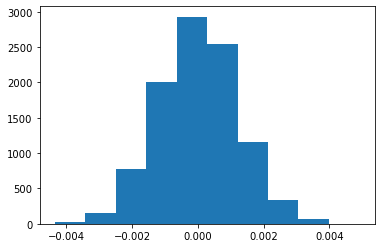

In [27]:
#look at the histogram for the proportion differences
plt.hist(p_diffs)

Given the central limit theorem, we see the histogram is normally distributed which is what we would expect. 

Now we check the proportion of the **p_diffs** which are greater than the actual difference observed in **ab_data.csv**:

In [28]:
#actual difference in data
diff_actual = prob_treat_converted - prob_control_converted
diff_actual
#proportion of p_diffs
p_diffs_df = pd.DataFrame(p_diffs) #change numpy array into pandas dataframe 
(p_diffs_df>diff_actual).mean()

0    0.9063
dtype: float64

#### Explanation of results for Method 1:

The value that was just calculated is the p-value (significance level).

This value was calculated by creating by looking at differences between two simulated normal distributions for the P-new and P_old values. This difference was calculated 10000 times using different normal distributions each time to create a simulated distribution for the values the difference could take. 

We then check our actual value of differences from the dataset against our simulated values, and see what proportion of our simulated disribution is higher than our actual value. 

Since **we obtain a high p-value much higher than the significance level (0.05)**, this means it is **highly likely that our actual value could have come from our simulated distribution** and so w**e fail to reject the null hypothesis**. 

#### We can say there is not significant evidence that the new page increases conversion rate. 

#### Method 2: Using Z-test to check data against null:

We will also use some built-in functions to check the above process and hopefully achieve similar results.  

First we calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm
#unique users who converted
uniq_convert2 = df2.query('converted == "1"')
#get amount of unique users who converted when shown the old page and new page
convert_old = len(uniq_convert2.query('landing_page=="old_page"').groupby(by='user_id'))
convert_new = len(uniq_convert2.query('landing_page=="new_page"').groupby(by='user_id'))
#get the amount of unique users in total who were shown the old page and the new page
n_old = len(df2.query('landing_page=="old_page"').groupby(by='user_id'))
n_new = len(df2.query('landing_page=="new_page"').groupby(by='user_id'))


Now we use the statsmodel function `stats.proportions_ztest` to compute the z-test statistic and associated p-value:

In [30]:
#use the t-statistic to obtain z-score and a p-value for our dataset
res = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old],value=0, alternative='larger', prop_var=False)
res #outputs z score and p value

(-1.3109241984234394, 0.9050583127590245)

#### Explanation of results for Method 2:

The **negative z-score** shows that the **mean amount of users converted with the new page is 1.3 standard deviations below the mean amount of users converted who were shown the old page**

The **p-value** is similar to the p-value calculated previously in method 1 and so the findings agree with each other. This new p-value also suggests as well that **since the p-value is much higher than the significance level**, we **fail to reject the null hypothesis**. We can say with statistical certainty there is no evidence that the new page obtains more conversions than the old page.

### Inferences for both methods:

We see from two different methods of hypothesis testing that the **p-value is high**, therefore our proportion differences in the data are very **likely to have been able to come from a distribution where the null hypothesis is true.**

Therefore in both methods, **we fail to reject the null hypothesis** and accept with statistical certainty:

p-new - p-old <= 0

<a id='regression'></a>
### Part III - A Logistical regression approach

In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.

Since each row is either a conversion or no conversion, **the most appropiate type of regression to use in this case in a logistic regression**

The goal of this section is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives. 

First we need to create in df2 a column for the model intercept, and create a dummy variable column for which page each user received.

In [31]:
#create a new copy of the dataframe and add an intercept column
df3 = df2.copy()
df3['intercept']=1
#get dummy variables
abdum = pd.get_dummies(df3['group'])
#add dummy variables to a new column in the dataframe
df3['ab_page']=abdum.iloc[:,[1]]
#check
df3.head(20)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


Now we use **statsmodels** to set up the regression model on the two columns we created. Then we will fit the model using the two columns to predict whether or not an individual converts. 

In [32]:
#create a logistic regression model 
logm = sm.Logit(df3['converted'],df3[['intercept','ab_page']])
res=logm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Check the logistic regression summary table:

In [33]:
#show the summary of the logistic regression 
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-07-31 15:49 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

### Explanation of Logistic regression results:

The p-value associated with ab_page is 0.1899. As this is higher than the level of significance, this means we **cannot reject the null hypothesis**. In this case the **null hypothesis is that the coefficient = 0**, in other words that the **independent variable has no impact on the dependent variable in the regression model**

Whereas previously our null hypothesis was that there was not a difference between the conversion rates for the new page and old and was comparing two values. Here in the logistic regression, our null hypothesis is only whether a coefficient for a variable could be zero.

#### Other factors to consider: ####

In this case, if we would want an accurate predictor of whether an individual converts or not, it would be a good idea to add other factors into our model. With the current factors, our model is not able to predict at all whether an individual will convert or not (shown by the pseudo-r-squared value of 0).

The main danger in adding more variables is that if you are not careful, the variables could end up violating the assumptions of logistic regression.

While these assumptions are less strict than for linear regression, there are still two which we should be aware of in this case:

1) Logistic regression requires observations to be independent of each other

2) Logistic regression requires there to be little or no multicollinearity among the independent variables [1](https://www.statisticssolutions.com/assumptions-of-logistic-regression/)

To take into consideration the above two rules, we should take care not to include a variable and a derivative of that same variable in the same regression. Also after each variable is added we should check for multicolinearity and if we find multicolinearity, it would be wise to remove one of these variables causing the issue. 

Another danger is that by adding variables with an interaction or polynomial expression, this can make our interpretation of the results of the regression more difficult. 

#### Adding additional variables to the Logistic regression:

We will add the country of each user to see if this changes the results of the regression analysis:

In [34]:
# read and examine countries csv file
countries = pd.read_csv('countries.csv')
countries.head()
#create a new dataframe by merging on the user ids of both tables
df4 = df3.merge(countries,how='inner',left_on='user_id',right_on='user_id')
#create dummy variables for country column
countries_dum = pd.get_dummies(df4['country'])
#add 2 dummy variables to dataframe (using UK users as the baseline)
df4['canada'] = countries_dum.iloc[:,[0]]
df4['USA'] = countries_dum.iloc[:,[2]]
#check to make sure variables added correctly
df4.head(20)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,canada,USA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0


In [35]:
#create another logistic regression
logmod2 = sm.Logit(df4['converted'],df4[['intercept','canada','USA']])
res = logmod2.fit()
#show results
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2020-07-31 15:49 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
canada       -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
USA          -0.0099    0.0133    -0.7458  0.4558  -0.0360   0.0161
==================================================================

"""

#### Results for regression with added country variable:

From the above logistic regression, we can see that the variables for **users from Canada and users from USA have p-values above the significance value**.

Thus we are **not able to reject the null hypothesis for each of these coefficients** and **cannot say with statistical significance that there is a significant difference between each variable and the baseline variable of users from the UK on whether a user will convert or not**.

Although we have now looked at the individual factors of country and page on conversion, we would now like to look at an **interaction between page and country** to see if there significant effects on conversion.  We will create the necessary additional columns, and fit the new model:

In [36]:
#create a new column for the interaction variables
df4['int_can_ab_page']=df4['canada']*df4['ab_page']
df4['int_USA_ab_page']=df4['USA']*df4['ab_page']
#create a new logarithmic regression
logmod3 = sm.Logit(df4['converted'],df4[['intercept','int_can_ab_page','int_USA_ab_page']])
res = logmod3.fit()
#show results
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212777.1060
Date:               2020-07-31 15:49 BIC:              212808.8450
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.030766   
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -1.9873   0.0072 -275.5728 0.0000 -2.0014 -1.9732
int_can_ab_page  -0.0842   0.0378   -2.2251 0.0261 -0.1583 -0.0100
int_USA_ab_page  -0.0197   0.0121   -1.6337 0.1023 -0.0434  0.0039
==================================================================

"""

#### Regression results with interaction variable:

After observing the results from the above logistic regression seeing if there is an interaction between country and whether a person was shown the new page, we can see that the as the coefficient for the **interaction between canada and ab_page, is below the signigicance level of 0.05, we reject the null hypothesis that this coefficient could be zero. **

As such it seems there is some **significant interaction between users from Canada and whether they were shown the new page and whether they will convert or not** meaning they are less likely to converrt compared to users from the UK. 

### Inferences:

From the above logistic regression, we can see that the values of the coefficient for when users were shown the new page, do not have a statistically significant impact on whether a user converts or not. 

However it could be that users from the UK are more likely to be converted when shown the new page as compared to users from the USA and Canada. But this would need to be investigated in more detail. 


<a id='conclusions'></a>
### Part IV - Conclusions

For our dataset we looked at some probabilities, two sets of hypothesis tests as well as some logarithmic regressions. From all the evidence gathered, **we can conclude with relative certainty that whether a user was shown the new page design, had no significant impact on whether the user would then convert or not**.

For the practical significance of these results, we can say that in terms of getting more users to convert, **it is not beneficial for this company to invest more time and resources in implementing the new page design as there is not a signifcant return on investment.** However perhaps the new page design is better when different metrics are examined such as total number of page visitors or length of time spent on the page and further analysis' could be undertaken to investigate.

It could also be worth investigating the difference in user behaviour from different countries, as perhaps targeted advertising could be beneficial if there is a difference in user behaviour across different countries.



In [37]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

255